<a href="https://colab.research.google.com/github/Kryptera-K/BA-Price-Momentum-Acceleration-with-Klinger-Volume-Trigger-Strategy/blob/main/BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BA"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BA_clean.csv", index=False)
df

/tmp/ipython-input-3912948154.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,25.940292,26.908515,25.698237,26.747144,2638200
2000-01-04,25.899935,26.545416,25.657879,25.940277,3592100
2000-01-05,27.513641,27.957410,26.706790,26.706790,7631700
2000-01-06,27.796036,28.038091,26.545416,27.513638,4922200
2000-01-07,28.602892,28.965975,28.199466,28.199466,6008300
...,...,...,...,...,...
2025-12-24,218.160004,219.270004,216.190002,217.000000,2943500
2025-12-26,216.440002,218.669998,216.139999,218.050003,2801500
2025-12-29,217.250000,218.139999,215.110001,215.899994,5292000


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

KVO_LEVEL = 0
KVO_LONG = 55
KVO_SHORT = 34
KVO_SIGNAL = 13
ROC_PERIOD = 10
ROC_SHIFT = 5

# -------------------------
# Indicator Functions
# -------------------------

def roc_rising(df, shift=ROC_SHIFT):
    df = calculate_roc(df)
    return df['ROC'] > df['ROC'].shift(shift)


def calculate_roc(df, period=ROC_PERIOD):
    """
    Calculate Rate of Change (ROC) for Close prices.
    """
    df = df.copy()
    df['ROC'] = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    return df


def kvo_cross_above_level(df, level=KVO_LEVEL):
    df = klinger_volume_oscillator(df)
    kvo = df['KVO']
    return (kvo > level) & (kvo.shift(1) <= level)


def klinger_volume_oscillator(df, short=KVO_SHORT, long=KVO_LONG, signal=KVO_SIGNAL):
    dm = df['High'] - df['Low']
    cm = np.cumsum(np.where(df['Close'] > df['Close'].shift(1), dm, -dm))
    vf = df['Volume'] * abs(2 * (df['Close'] - df['Low']) / (df['High'] - df['Low']) - 1)
    kvo = vf.ewm(span=short).mean() - vf.ewm(span=long).mean()
    df['KVO'] = kvo
    df['KVO_Signal'] = kvo.ewm(span=signal).mean()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["ROC_Rising"] = roc_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["KVO_Cross_Above_Zero"] = kvo_cross_above_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'ROC_Rising',
]
exit_conditions = [
    'KVO_Cross_Above_Zero',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-26 00:00:00
Period                         6536 days 00:00:00
Start Value                              100000.0
End Value                           815227.765194
Total Return [%]                       715.227765
Benchmark Return [%]                   715.227765
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        77.328233
Max Drawdown Duration          1716 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      715227.765194
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


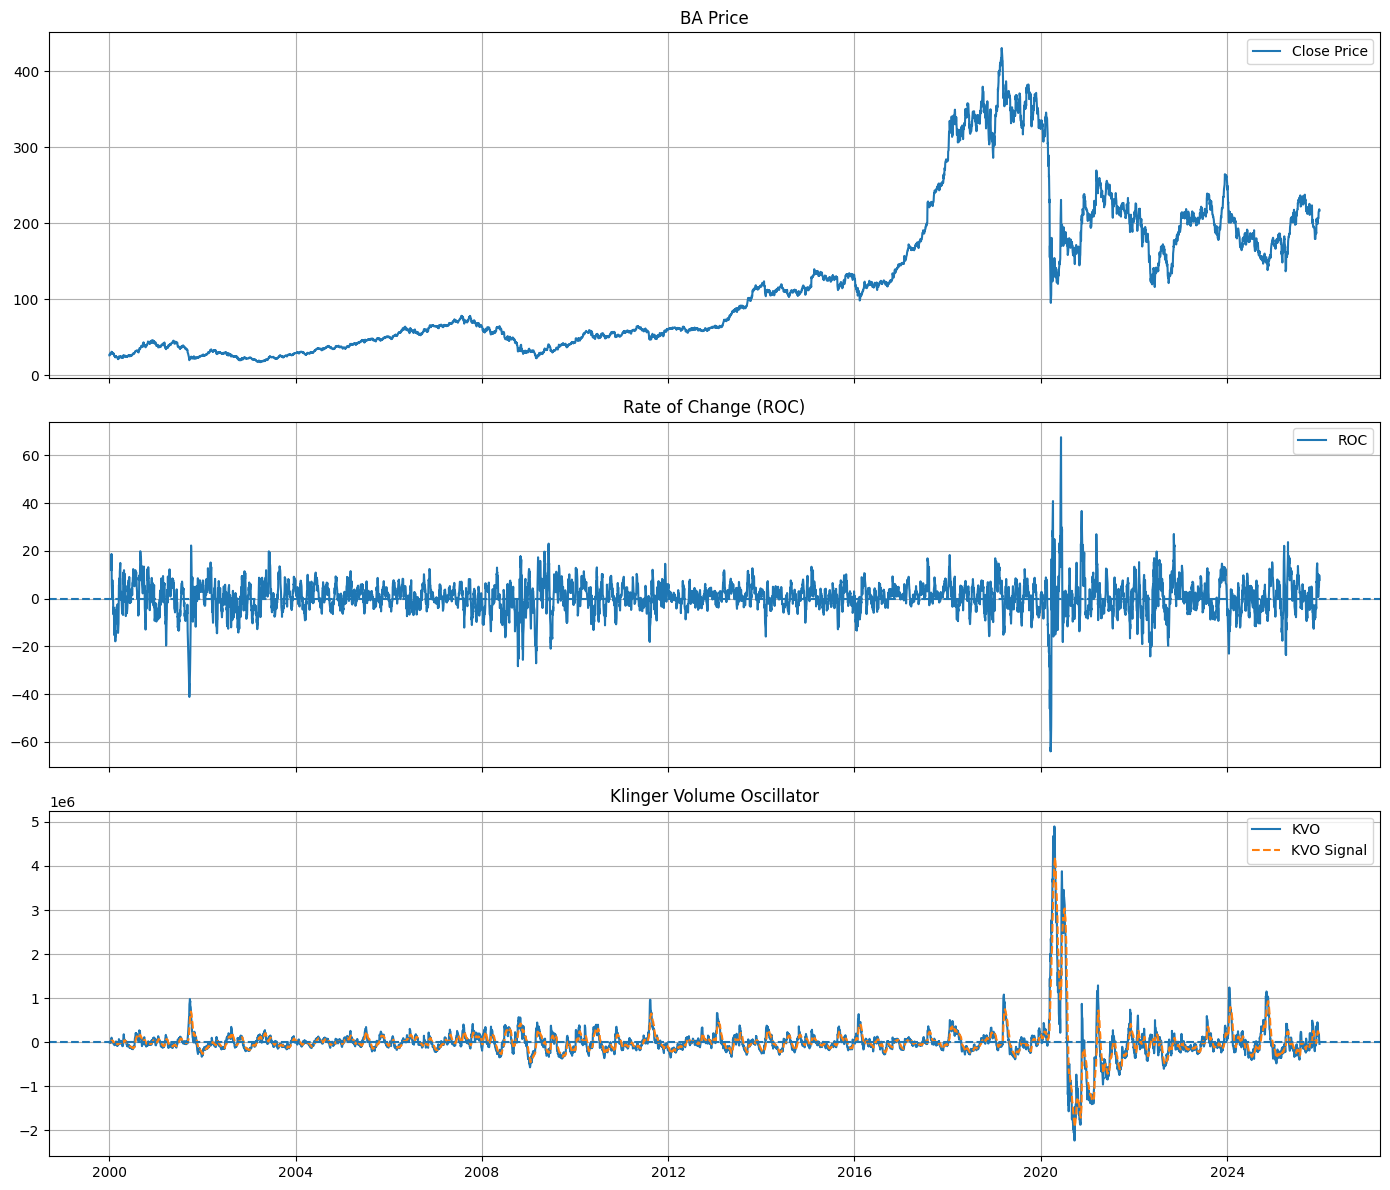

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Calculate Indicators
# -------------------------

# ROC
df = calculate_roc(df)

# ROC Rising condition (boolean)
df["ROC_Rising"] = roc_rising(df)

# KVO + Signal
df = klinger_volume_oscillator(df)

# KVO Cross Above Level (signal)
df["KVO_Cross_Above_0"] = kvo_cross_above_level(df)


fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# =========================
# 1. Price Chart
# =========================
axes[0].plot(df.index, df["Close"], label="Close Price")
axes[0].set_title("BA Price")
axes[0].legend()
axes[0].grid(True)

# =========================
# 2. ROC Indicator
# =========================
axes[1].plot(df.index, df["ROC"], label="ROC")
axes[1].axhline(0, linestyle="--")
axes[1].set_title("Rate of Change (ROC)")
axes[1].legend()
axes[1].grid(True)

# =========================
# 3. Klinger Volume Oscillator
# =========================
axes[2].plot(df.index, df["KVO"], label="KVO")
axes[2].plot(df.index, df["KVO_Signal"], linestyle="--", label="KVO Signal")
axes[2].axhline(KVO_LEVEL, linestyle="--")
axes[2].set_title("Klinger Volume Oscillator")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()
